In [1]:
%load_ext lab_black

# Анализ рекламной кампании развлекательного приложения
**Цель проекта:**  
Анализ развлекательного приложения Procrastinate Pro+. Нужно оценить окупаемость рекламных кампаний для повышения эффективности бизнеса.
Необходимо изучить:
- как люди пользуются продуктом, 
- когда они начинают покупать, 
- сколько денег приносит каждый клиент, 
- когда он период окупаемости
- факторы влияющие на привлечение пользователей.  

**Имеющиеся данные**  
- лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27,  
- выгрузка их покупок за этот период, 
- статистика рекламных расходов.     

**Ход исследования**  
- предобработка данных
- исследовательский анализ
- анализ маркетинговых мероприятий
- анализ *окупаемости рекламы*:  
    - в целом, 
    - по устройствам, 
    - по рекламным каналам,
    - по странам
- анализ *конверсии*:  
    - в целом, 
    - по устройствам, 
    - по рекламным каналам,
    - по странам
- анализ *удержания* :  
    - в целом, 
    - по устройствам, 
    - по рекламным каналам,
    - по странам    

## Изучение данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
from datetime import datetime, timedelta

In [3]:
local_path = "./"
server_path = "/datasets/"
files = ["costs_info_short", "orders_info_short", "visits_info_short"]
data_frames = []
for file in files:
    try:
        exec(f"data_{file[:-11]} = pd.read_csv('{local_path}{file}.csv')")
        data_frames.append(f"data_{file[:-11]}")
    except:
        exec(f"data_{file[:-11]} = pd.read_csv('{server_path}{file}.csv')")
        data_frames.append(f"data_{file[:-11]}")

In [4]:
for df in data_frames:
    print(df)
    locals().get(df).info()
    display(locals().get(df).head())
    print("\n", "_" * 50, "\n")

data_costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1



 __________________________________________________ 

data_orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



 __________________________________________________ 

data_visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



 __________________________________________________ 



In [5]:
# переименуем названия столбцов в DF
def new_columns(df):
    df.columns = [x.lower().replace(" ", "_") for x in df.columns.values]


for df in data_frames:
    new_columns(locals().get(df))

In [6]:
# проверим дубликаты
for df in data_frames:
    print(f"{df} содержит {locals().get(df).duplicated().sum()} дублирующих строк")
    print("")

data_costs содержит 0 дублирующих строк

data_orders содержит 0 дублирующих строк

data_visits содержит 0 дублирующих строк



In [7]:
data_costs["dt"] = pd.to_datetime(data_costs["dt"])
data_costs["month"] = data_costs["dt"].dt.month
data_orders["event_dt"] = pd.to_datetime(data_orders["event_dt"])
data_visits["session_start"] = pd.to_datetime(data_visits["session_start"])
data_visits["session_end"] = pd.to_datetime(data_visits["session_end"])

Методом info() получена общая информация по всем DataFrame.  
    
Пустые значения во всех столбцах всех DF отсутствуют.
    
Названия столбцов во всех DF имеют нарушения стандарта PEP8 - смешение нижнего и верхних регистров, пробелы в наименованиях из нескольких строк. Для перименования использовали собственную функцию. 
    
Типы данных столбцов содержащие даты: 
- "data_costs" - dt, 
- "data_orders" - Event Dt,
- "data_visits" - Session Start и Session End
    
в них данные представлены в виде строк.  
Для использования их в дальнейших расчетах необходимо привести к типу данных datetime.  

Все DF не содержат дублирующих строк.
    
В разных DF одинаковые столбцы (например user_id) имеют один тип данных, это упростит объединение таблиц.


# Функции для расчета и анализа LTV, ROI, удержания и конверсии

## _Функция для расчёта удержания_

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ["payer"] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")

    result_raw = result_raw.merge(
        sessions[["user_id", "session_start"]], on="user_id", how="left"
    )
    result_raw["lifetime"] = (
        result_raw["session_start"] - result_raw["first_ts"]
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns="lifetime", values="user_id", aggfunc="nunique"
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({"user_id": "nunique"})
            .rename(columns={"user_id": "cohort_size"})
        )
        result = cohort_sizes.merge(result, on=dims, how="left").fillna(0)
        result = result.div(result["cohort_size"], axis=0)
        result = result[["cohort_size"] + list(range(horizon_days))]
        result["cohort_size"] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(result_raw, dimensions + ["dt"], horizon_days)

    return result_raw, result_grouped, result_in_time

## _Функция для расчёта конверсии_

In [9]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )

    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")

    first_purchases = (
        purchases.sort_values(by=["user_id", "event_dt"])
        .groupby("user_id")
        .agg({"event_dt": "first"})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[["user_id", "event_dt"]], on="user_id", how="left"
    )

    result_raw["lifetime"] = (result_raw["event_dt"] - result_raw["first_ts"]).dt.days

    if len(dimensions) == 0:
        result_raw["cohort"] = "All users"
        dimensions = dimensions + ["cohort"]

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns="lifetime", values="user_id", aggfunc="nunique"
        )

        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({"user_id": "nunique"})
            .rename(columns={"user_id": "cohort_size"})
        )
        result = cohort_sizes.merge(result, on=dims, how="left").fillna(0)

        result = result.div(result["cohort_size"], axis=0)
        result = result[["cohort_size"] + list(range(horizon_days))]
        result["cohort_size"] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if "cohort" in dimensions:
        dimensions = []

    result_in_time = group_by_dimensions(result_raw, dimensions + ["dt"], horizon_days)

    return result_raw, result_grouped, result_in_time

## _Функция для расчёта LTV и ROI_

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )

    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")

    result_raw = result_raw.merge(
        purchases[["user_id", "event_dt", "revenue"]], on="user_id", how="left"
    )

    result_raw["lifetime"] = (result_raw["event_dt"] - result_raw["first_ts"]).dt.days

    if len(dimensions) == 0:
        result_raw["cohort"] = "All users"
        dimensions = dimensions + ["cohort"]

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(
            index=dims, columns="lifetime", values="revenue", aggfunc="sum"
        )

        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({"user_id": "nunique"})
            .rename(columns={"user_id": "cohort_size"})
        )

        result = cohort_sizes.merge(result, on=dims, how="left").fillna(0)

        result = result.div(result["cohort_size"], axis=0)

        result = result[["cohort_size"] + list(range(horizon_days))]

        result["cohort_size"] = cohort_sizes

        cac = df[["user_id", "acquisition_cost"] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({"acquisition_cost": "mean"})
            .rename(columns={"acquisition_cost": "cac"})
        )

        roi = result.div(cac["cac"], axis=0)

        roi = roi[~roi["cohort_size"].isin([np.inf])]

        roi["cohort_size"] = cohort_sizes

        roi["cac"] = cac["cac"]

        roi = roi[["cohort_size", "cac"] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if "cohort" in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ["dt"], horizon_days
    )

    return (
        result_raw,
        result_grouped,
        result_in_time,
        roi_grouped,
        roi_in_time,
    )

## _Функции для визуализации_

In [11]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [12]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=["cohort_size", 0])

    retention_history = retention_history.drop(columns=["cohort_size"])[[horizon - 1]]

    if retention.index.nlevels == 1:
        retention["cohort"] = "All users"
        retention = retention.reset_index().set_index(["cohort", "payer"])

    ax1 = plt.subplot(2, 2, 1)
    retention.query("payer == True").droplevel("payer").T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("Удержание платящих пользователей")

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query("payer == False").droplevel("payer").T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("Удержание неплатящих пользователей")

    ax3 = plt.subplot(2, 2, 3)

    columns = [
        name for name in retention_history.index.names if name not in ["dt", "payer"]
    ]

    filtered_data = retention_history.query("payer == True").pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )

    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика удержания платящих пользователей на {}-й день".format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query("payer == False").pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel("Дата привлечения")
    plt.title(
        "Динамика удержания неплатящих пользователей на {}-й день".format(horizon)
    )

    plt.tight_layout()
    plt.show()

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=["cohort_size"])
    conversion_history = conversion_history.drop(columns=["cohort_size"])[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("Конверсия пользователей")

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ["dt"]]
    filtered_data = conversion_history.pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика конверсии пользователей на {}-й день".format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=["cohort_size"])

    ltv_history = ltv_history.drop(columns=["cohort_size"])[[horizon - 1]]

    cac_history = roi_history[["cac"]]

    roi = roi.drop(columns=["cohort_size", "cac"])

    roi_history = roi_history.drop(columns=["cohort_size", "cac"])[[horizon - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("LTV")

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)

    columns = [name for name in ltv_history.index.names if name not in ["dt"]]
    filtered_data = ltv_history.pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика LTV пользователей на {}-й день".format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ["dt"]]
    filtered_data = cac_history.pivot_table(
        index="dt", columns=columns, values="cac", aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика стоимости привлечения пользователей")

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color="red", linestyle="--", label="Уровень окупаемости")
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("ROI")

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)

    columns = [name for name in roi_history.index.names if name not in ["dt"]]
    filtered_data = roi_history.pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color="red", linestyle="--", label="Уровень окупаемости")
    plt.xlabel("Дата привлечения")
    plt.title("Динамика ROI пользователей на {}-й день".format(horizon))

    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных

## _Функция для создания пользовательских профилей_

In [15]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=["user_id", "session_start"])
        .groupby("user_id")
        .agg(
            {
                "session_start": "first",
                "channel": "first",
                "device": "first",
                "region": "first",
            }
        )
        .rename(columns={"session_start": "first_ts"})
        .reset_index()
    )

    profiles["dt"] = profiles["first_ts"].dt.date
    profiles["month"] = profiles["first_ts"].astype("datetime64[M]")

    profiles["payer"] = profiles["user_id"].isin(orders["user_id"].unique())

    new_users = (
        profiles.groupby(["dt", "channel"])
        .agg({"user_id": "nunique"})
        .rename(columns={"user_id": "unique_users"})
        .reset_index()
    )

    new_users["dt"] = pd.to_datetime(new_users["dt"])

    ad_costs = ad_costs.merge(new_users, on=["dt", "channel"], how="left")

    ad_costs["acquisition_cost"] = ad_costs["costs"] / ad_costs["unique_users"]

    profiles["dt"] = pd.to_datetime(profiles["dt"])

    profiles = profiles.merge(
        ad_costs[["dt", "channel", "acquisition_cost"]],
        on=["dt", "channel"],
        how="left",
    )

    profiles["acquisition_cost"] = profiles["acquisition_cost"].fillna(0)

    return profiles

In [16]:
profiles = get_profiles(data_visits, data_orders, data_costs)

In [17]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
min_date = data_visits["session_start"].dt.date.min()
max_date = data_visits["session_start"].dt.date.max()

In [19]:
print(
    f"Максимальная дата привлечения пользователей: {max_date}\nМинимальная дата привлечения пользователей: {min_date}"
)

Максимальная дата привлечения пользователей: 2019-10-31
Минимальная дата привлечения пользователей: 2019-05-01


## _Функция для определения числа платящих / не платящих пользователей по категориям_

In [20]:
def get_groups(profiles, dimention):
    return_group = (
        profiles.groupby([str(dimention), "payer"])
        .agg({"payer": "count"})
        .rename(columns={"payer": "count_payers"})
        .reset_index()
    )
    state_group = (
        profiles.groupby([str(dimention)])
        .agg({"payer": "count"})
        .rename(columns={"payer": "sum_payers"})
        .reset_index()
    )

    return_group = return_group.merge(state_group, on=[str(dimention)])

    return_group["share_payers"] = (
        return_group["count_payers"].div(return_group["sum_payers"]) * 100
    ).round(1)

    payers_by_dimention = (
        return_group.loc[return_group["payer"] == True]
        .sort_values(by="count_payers", ascending=False)
        .reset_index(drop=True)
    )
    return (
        return_group.loc[:, return_group.columns != "sum_payers"],
        payers_by_dimention.iloc[:, return_group.columns != "sum_payers"],
    )

In [21]:
# получим данные о платящих и не платящих пользователях в разрезе стран
group_country, payers_by_country = get_groups(profiles, "region")

In [22]:
group_country

,region,payer,count_payers,share_payers
0,France,False,16787,96.2
1,France,True,663,3.8
2,Germany,False,14365,95.9
3,Germany,True,616,4.1
4,UK,False,16875,96.0
5,UK,True,700,4.0
6,United States,False,93100,93.1
7,United States,True,6902,6.9


In [23]:
payers_by_country

,region,payer,count_payers,share_payers
0,United States,True,6902,6.9
1,UK,True,700,4.0
2,France,True,663,3.8
3,Germany,True,616,4.1


In [24]:
# проанализируем доли и число платящих / не платящих пользователей в разрезе устройств
group_device, payers_by_device = get_groups(profiles, "device")

In [25]:
group_device

,device,payer,count_payers,share_payers
0,Android,False,32982,94.1
1,Android,True,2050,5.9
2,Mac,False,28130,93.6
3,Mac,True,1912,6.4
4,PC,False,28918,95.0
5,PC,True,1537,5.0
6,iPhone,False,51097,93.8
7,iPhone,True,3382,6.2


In [26]:
payers_by_device

,device,payer,count_payers,share_payers
0,iPhone,True,3382,6.2
1,Android,True,2050,5.9
2,Mac,True,1912,6.4
3,PC,True,1537,5.0


In [27]:
# проанализируем в разрезе рекламного канала долю и число платящих и неплатящих пользователей
group_channel, payers_by_channel = get_groups(profiles, "channel")

In [28]:
group_channel

,channel,payer,count_payers,share_payers
0,AdNonSense,False,3440,88.7
1,AdNonSense,True,440,11.3
2,FaceBoom,False,25587,87.8
3,FaceBoom,True,3557,12.2
4,LeapBob,False,8291,96.9
5,LeapBob,True,262,3.1
6,MediaTornado,False,4208,96.4
7,MediaTornado,True,156,3.6
8,OppleCreativeMedia,False,8372,97.3
9,OppleCreativeMedia,True,233,2.7


In [29]:
payers_by_channel

,channel,payer,count_payers,share_payers
0,FaceBoom,True,3557,12.2
1,TipTop,True,1878,9.6
2,organic,True,1160,2.1
3,WahooNetBanner,True,453,5.3
4,AdNonSense,True,440,11.3
5,RocketSuperAds,True,352,7.9
6,LeapBob,True,262,3.1
7,OppleCreativeMedia,True,233,2.7
8,lambdaMediaAds,True,225,10.5
9,YRabbit,True,165,3.8


### Вывод 
На основании составленных профилей пользователей можно сделать следующие выводы:  
    
- пользователями сервиса являются жители 3 стран Европы ( Великобритания, Франция и Германия), а также США. При этом наибольшее число платящих пользователей в США (6902 чел.) и их доля от общего числа пользователей страны 6,9%.  
Наименьшее чисо платящих пользователей в Германии - 616 человек, однако их доля от общего числа пользователей страны составляет 4,1% (второе место после США).  
- пользователи используют устройства 4 типов: Android, iPhone, Mac, PC.  
Наибольшее число платящих пользователей (3382 чел.) используют устройства iPhone (6,2% от всех пользователей приложения заходящих с iPhone). Наименьшее число пользователей у устройств PC (1537 чел.) и доля платящих пользователей таких устройств также самая низкая - 5,0% от все пользователей PC.  
- в разрезе канала привлечения наибольшее число платящих пользователей пришло с FaceBoom (3557 чел), что составляет 12,2% от всех привлеченных этим каналом пользователей. Наименьшее число платящих пользователей у канала MediaTornado - 156 человек, это 3,6% от общего числа привлеченных каналом пользователей.

# Анализ маркетинга

In [30]:
(f"Суммарные затраты на маркетинг составили {data_costs['costs'].sum():,.0f} единиц")

'Суммарные затраты на маркетинг составили 105,497 единиц'

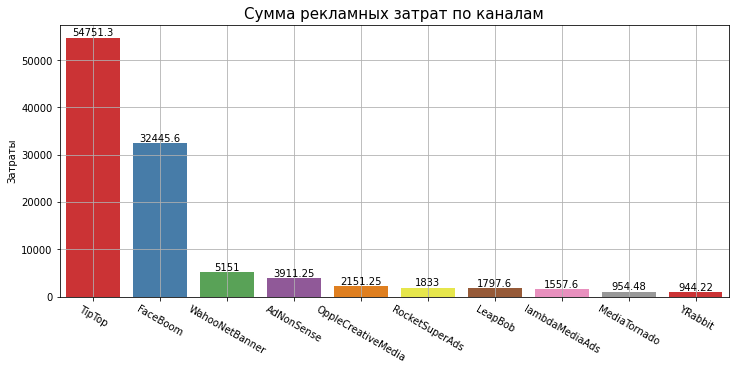

In [31]:
# построим график, показывающий сумму рекламных затрат по каналам привлечения
cost_channel = (
    data_costs.groupby("channel")
    .agg({"costs": "sum"})
    .sort_values(by="costs", ascending=False)
    .reset_index()
)

plt.figure(figsize=(12, 5))

bchart = sns.barplot(data=cost_channel, x="channel", y="costs", palette="Set1")
bchart.bar_label(bchart.containers[0])

plt.grid()
plt.xlabel("")
plt.ylabel("Затраты")
plt.xticks(rotation=-30)
plt.title("Сумма рекламных затрат по каналам", size=15)
plt.show()

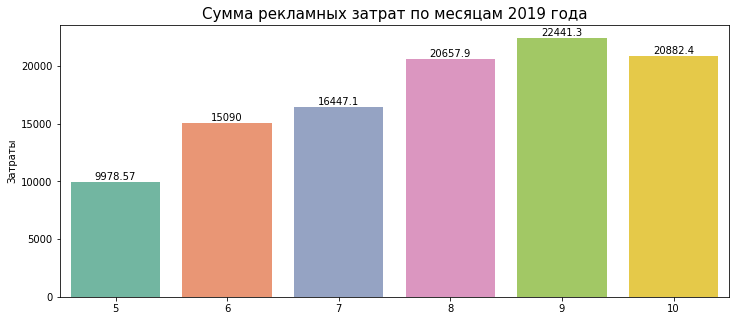

In [32]:
# построим график динамики рекламных затрат по месяцам 2019 года
cost_date = data_costs.groupby("month").agg({"costs": "sum"}).reset_index()

plt.figure(figsize=(12, 5))
bchart = sns.barplot(data=cost_date, x="month", y="costs", palette="Set2")
bchart.bar_label(bchart.containers[0])

plt.xlabel("")
plt.ylabel("Затраты")
plt.title("Сумма рекламных затрат по месяцам 2019 года", size=15)
plt.show()

In [33]:
# расчитаем показатель САС - стоимость привлечения покупателя по проекту в целом
total_ad = data_costs["costs"].sum()
total_users = profiles.query('channel != "organic"').count()["user_id"]
cac_avg = total_ad / total_users
print(f"Средний CAC по проекту составляет {cac_avg}")

Средний CAC по проекту составляет 1.127481323942759


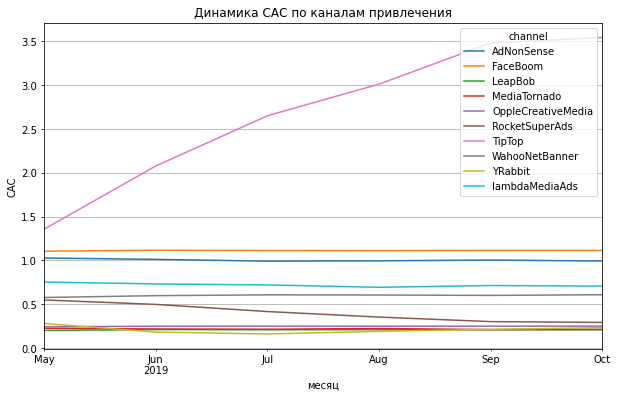

In [34]:
# построим график динамики САС по каналам кроме органики
profiles.query('channel != "organic"').pivot_table(
    index="month", columns="channel", values="acquisition_cost", aggfunc="mean"
).plot(grid=True, figsize=(10, 6))
plt.xlabel("месяц")
plt.ylabel("CAC")
plt.title("Динамика САС по каналам привлечения")
plt.show()

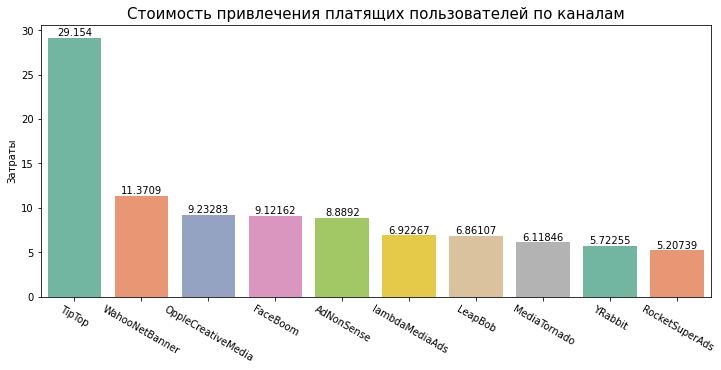

In [35]:
# построим диаграмму стоимости привлечения только платящих пользователей по каналам (за исключением органики)
cap = (
    profiles.query('channel != "organic"')
    .groupby("channel")
    .agg({"payer": sum, "acquisition_cost": sum})
)
cap["CAP"] = cap["acquisition_cost"] / cap["payer"]

plt.figure(figsize=(12, 5))
bchart = sns.barplot(
    data=cap.reset_index().sort_values(by="CAP", ascending=False),
    x="channel",
    y="CAP",
    palette="Set2",
    # order=cap['CAP']
)
bchart.bar_label(bchart.containers[0])
plt.xticks(rotation=-30)
plt.xlabel("")
plt.ylabel("Затраты")
plt.title("Стоимость привлечения платящих пользователей по каналам", size=15)
plt.show()

## Вывод 
Анализ маркетинговых затрат в разрезе периодов (месяцев 2019 года) и каналов привлечения покупателей позволяет сделать следующие выводы:  

- максимальные суммарные маркетинговые затраты по каналам привлечения наблюдаются у TipTop (54751.30 единиц) и FaceBoom (32445.60 единиц). Затраты остальных каналов не превышают 6000 единиц.
- сумма ежемесячных маркетинговых затрат имеет устойчивую динамику на рост с мая по сентябрь. В октябре незначительное снижение до уровня августа.  
  
- лидеры по средней стоимости привлечения 1 покупателя в разрезе канала составила: TipTop- 29.15, WahooNetBanner - 11.37, OppleCreativeMedia - 9.23, FaceBoom - 9.12. В остальных каналов данный показатель не превышает 9.0.


# Оценка окупаемости рекламы для привлечения пользователей

## Общая окупаемость рекламы

In [36]:
# по бизнес-требованиям дата анализа 01.11.2019, период окупаемости 14 дней
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

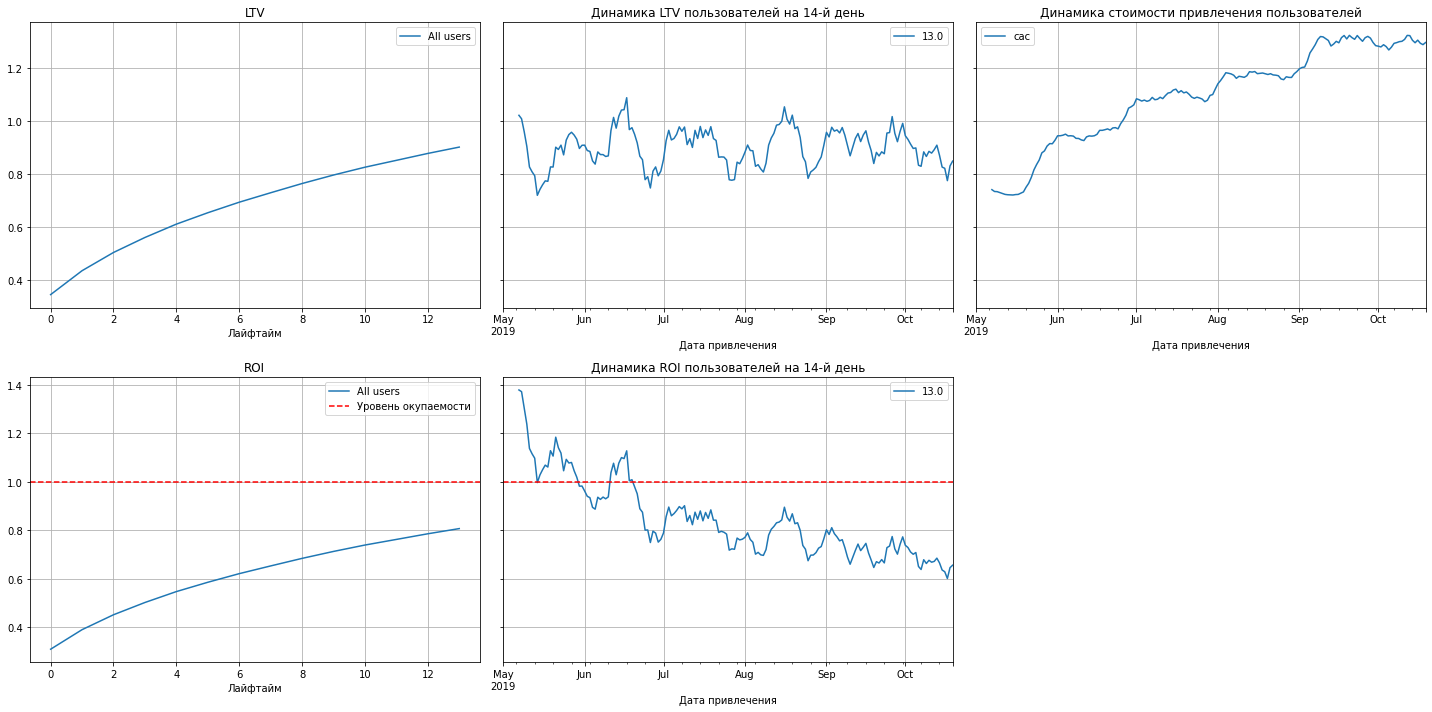

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), data_orders, observation_date, horizon_days
)


plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

### Вывод 
Анализ общей окупаемости рекламы:  

- в целом реклама не окупается - ROI на в конце двухнедельного срока окупаемости ниже 1.0.  
- динамика ROI пользователей на 14 день имеет ярко выраженный нисходящий тренд - окупаемость инвестии снизилась с прибыльного уровня в мае-июле ниже отметки безубыточности в августе и продолжает снижаться.   
- стоимость привлечения 1 клиента (САС) увеличилась с 0.75 в мае до 1.3 в октябре. Это необходимо проанализировать глубже.
- колебания LTV пользователей на 14 день незначительные.


## Окупаемость рекламы с разбивкой по устройствам

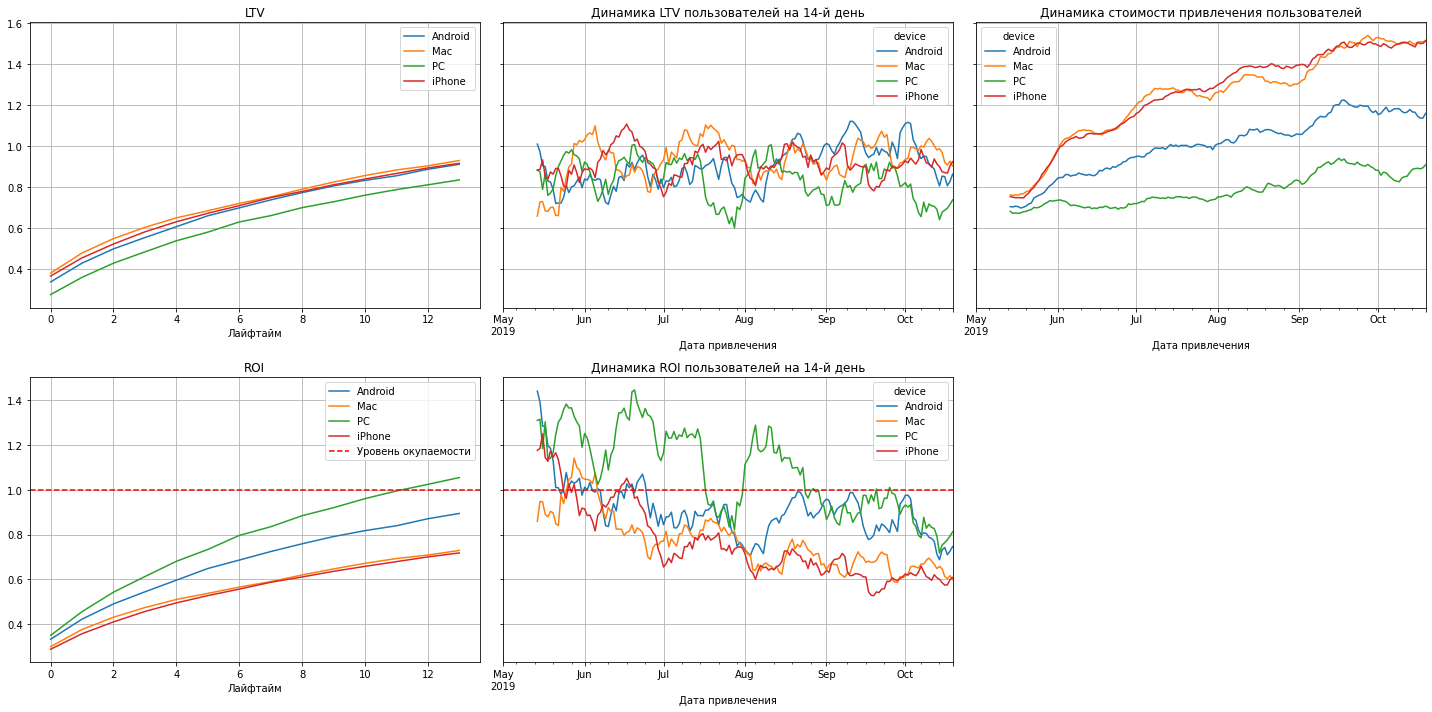

In [38]:
dimensions = ["device"]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    data_orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

### Вывод
Анализ окупаемости рекламы с разбивкой по устройствам:  

- ROI выше значения окупаемости только на платформе PC на 11 лайфтайм, а на Android, Mac и IPhone ниже во всех лайфтаймах.  
- динамика ROI пользователей на 14 день на платформе PC до сентября выше уровня окупаемости, далее опустилась ниже этого уровня. По остальным платформам ситуация еще менее благополучная - ROI пользователей на 14 день  Mac и IPhone с июля опустился ниже уровня окупаемости и продолжает снижаться. ROI пользователей на 14 день платформы Android с июля снизилось ниже уровня окупаемости, однако наблюдаются колебания направленные вверх к этому уровню.
- стоимость привлечения 1 клиента (САС) по всем патформам резко возрасла в июле и в последующие месяцы продолжила расти. Наиболее существенный рост у платформ Mac и IPhone.


## Окупаемость рекламы с разбивкой по странам

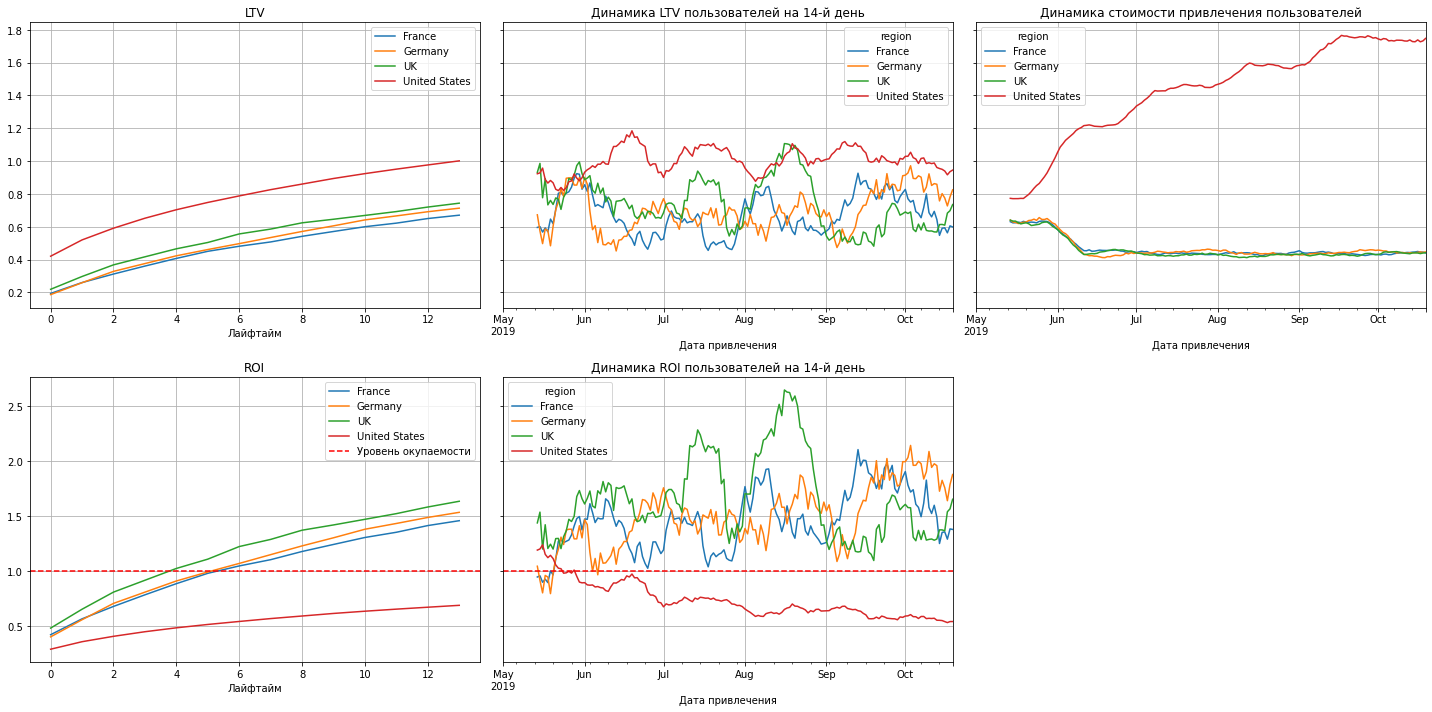

In [39]:
dimensions = ["region"]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    data_orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

### Вывод 

Анализ окупаемости рекламы с разбивкой по странам:  

- в европейских странах ROI покупателей выходит на прибыльный уровень с 4-5 дни, в то время как в США показатель ROI стабильно ниже уровня окупаемости.  
- динамика ROI пользователей на 14 день на платформе в европейских странах во всех месяцах выше уровня окупаемости. ROI пользователей из США на 14 день с июня опустилось ниже уровня окупаемости и продолжает снижаться.
- стоимость привлечения 1 клиента (САС) по покупателям из США патформам резко возрасла в июле и в последующие месяцы продолжила расти. Стоимость привлечения покупателей из Европы в июне снизилась и далее находится примерно на одном уровне.  
- LTV северо-американских покупателей выше, чем европейских практически во всех наблюдаемых периодах.   


## Окупаемость рекламы с разбивкой по рекламным каналам

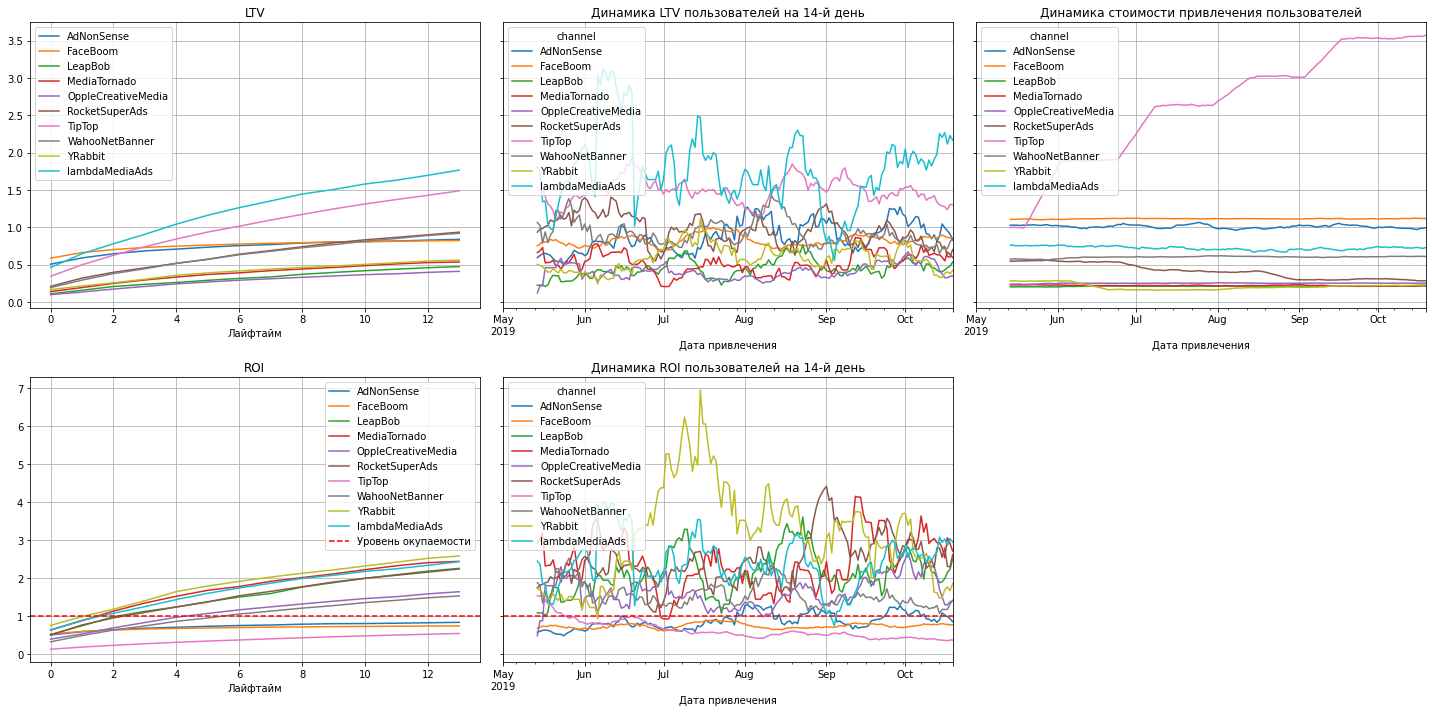

In [40]:
dimensions = ["channel"]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    data_orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

### Вывод 
Анализ окупаемости рекламы с разбивкой по рекламным каналам:  

- ROI пользователей привлеченных через каналы TipTop, FaceBoom, AdNonSense устойчиво убыточны.  Во всех остальных случаях прибыль получается на 2-5 лайфтайм.
- динамика ROI пользователей на 14 день во всех месяцах выше уровня окупаемости по всем каналам кроме TipTop, FaceBoom, AdNonSense. Наиболее высокие значения показателя получены по каналу YRabbit.
- стоимость привлечения 1 клиента (САС) по покупателям привлекаеым через канал TipTop резко возросла в июле и в последующие месяцы продолжила скачкообразно расти. Стоимость привлечения покупателей по другим каналам имеет стабильное положение во всем периоде наблюдения.  
- наиболее высокие LTV покупателей наблюдаются по каналам lambdaMediaAds и TipTop.   


## Анализ конверсии в разрезе устройств

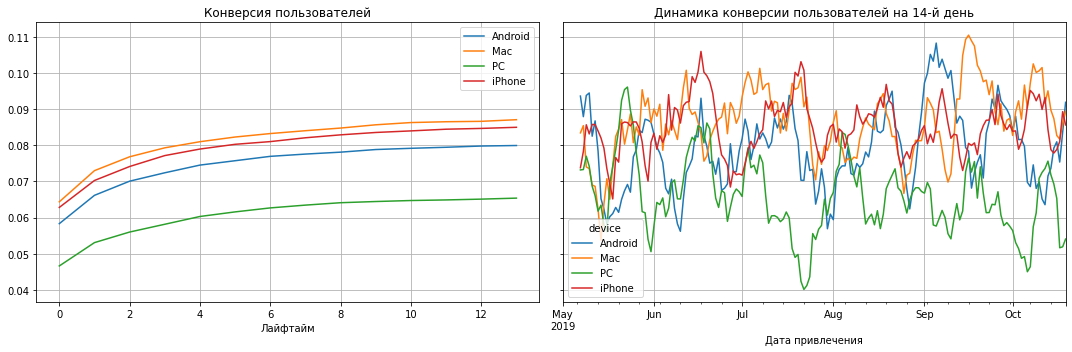

In [41]:
dimensions = ["device"]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    data_orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### Вывод 
Анализ конверсии покупателей с разбивкой по устройствам:  

- наиболее успешно конвертируются в покупателей пользователи устройств Mac и IPhone, Android несколько хуже, а PC наименее успешно.
- динамика LVT на 14 день во всех месяцах имеет примерно равный тренд для всех устройств, но на своих уровнях.


## Анализ конверси в разрезе стран

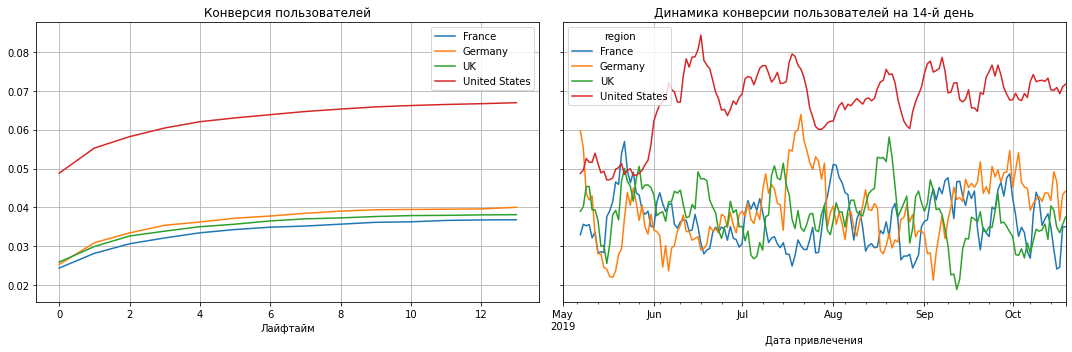

In [42]:
dimensions = ["region"]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, data_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### Вывод
Анализ конверсии покупателей с разбивкой по странам:  

- наиболее успешно конвертируются в покупателей пользователи из США, европейские пользователи в этом показателе знчительно им уступают. Отчетливо виден скачок конверсии в июне, далее волатильность показателя не такая высокая и продолжает умньшать к окончанию периода наблюдения.
- динамика LVT на 14 день северо-американских пользователей во всех периодах выше всех остальных стран, исключение составляет краткий период в июне.


## Анализ удержания в разрезе устройств

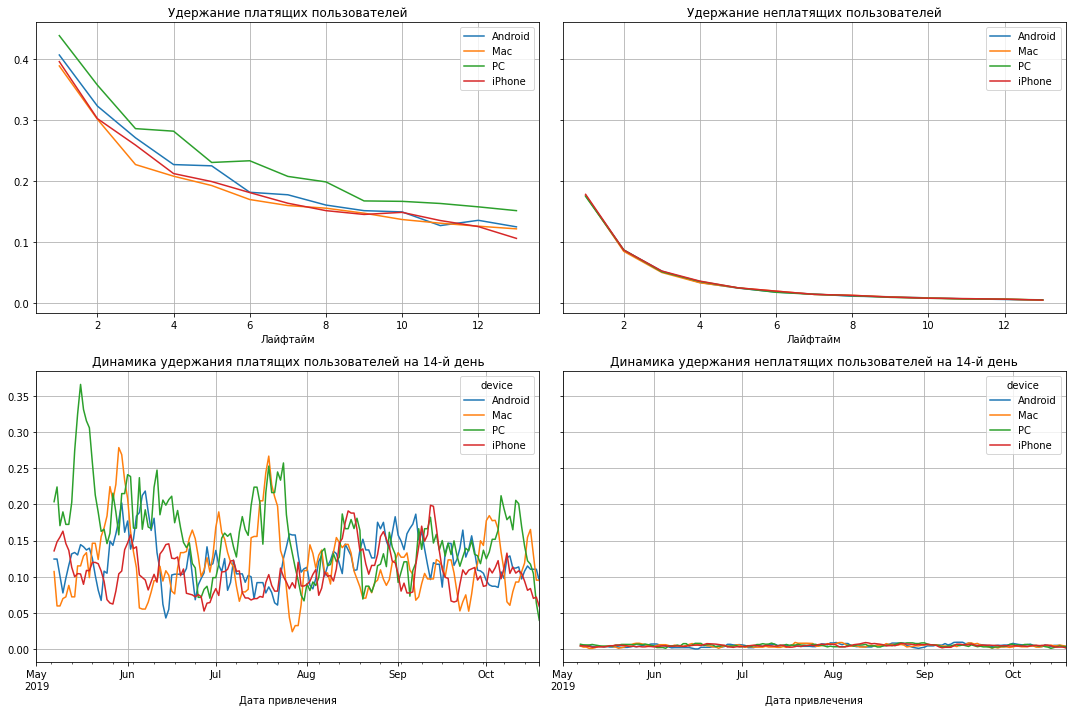

In [43]:
dimensions = ["device"]
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, data_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

### Вывод 
Анализ удержания покупателей с разбивкой по устройствам:  

- удержание платящих пользователей на платформе PC самое высокое по сравнению со остальными на протяжении всех лайфтаймов, однако значительное снижение удержания к 14 дню присуще всем платформам.  
- динамика удержания на 14 день платформы PC по месяцам показывает, что пользователи этого канала удерживаются лучше всех остальных каналов практически на протяжении всего периода наблюдения. 
- удержание неплатящих пользователей на всех платформах находится на примерно однаковом уровне.


## Анализ удержания в разрезе стран

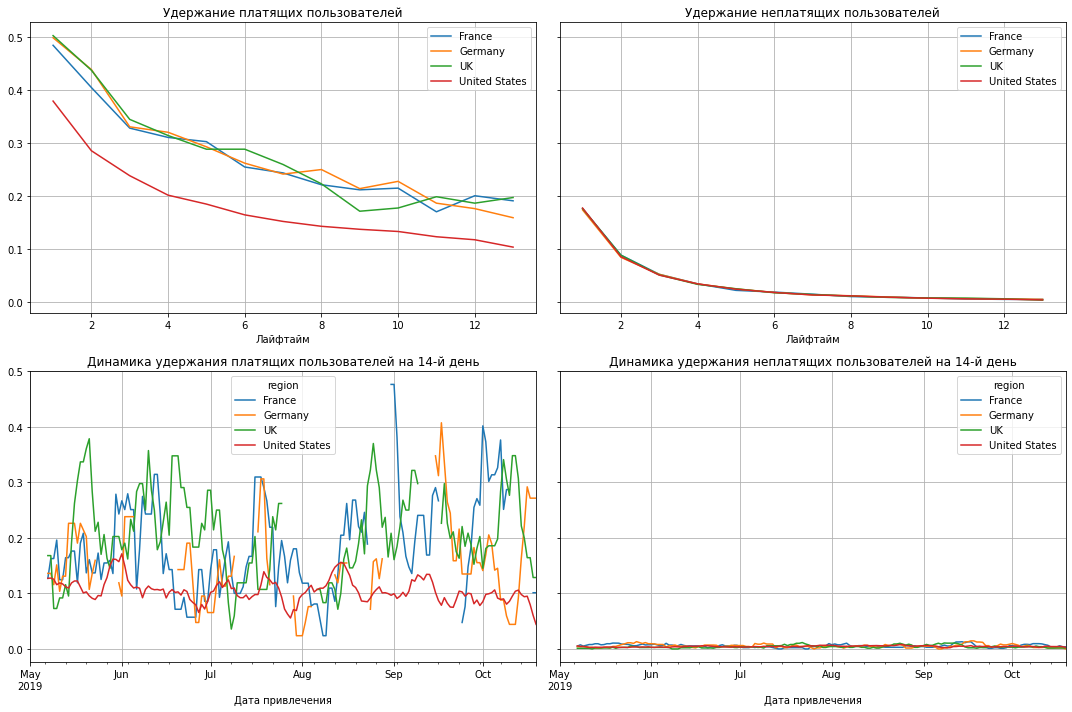

In [44]:
dimensions = ["region"]
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, data_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

### Вывод 
Анализ удержания покупателей с разбивкой по странам:  

- удержание платящих пользователей из США самое низкое по сравнению с европейскими пользователями на протяжении всех лайфтаймов.  
- динамика удержания на 14 день покупателей из Франции показывает, что эти пользователи лучше всех остальных каналов практически на протяжении всего периода наблюдения. Динамика удержания пользователей из США наименее подвержена пикам и спадам по сравнению с другими странами.
- удержание неплатящих пользователей во всех странах находится на примерно однаковом уровне.


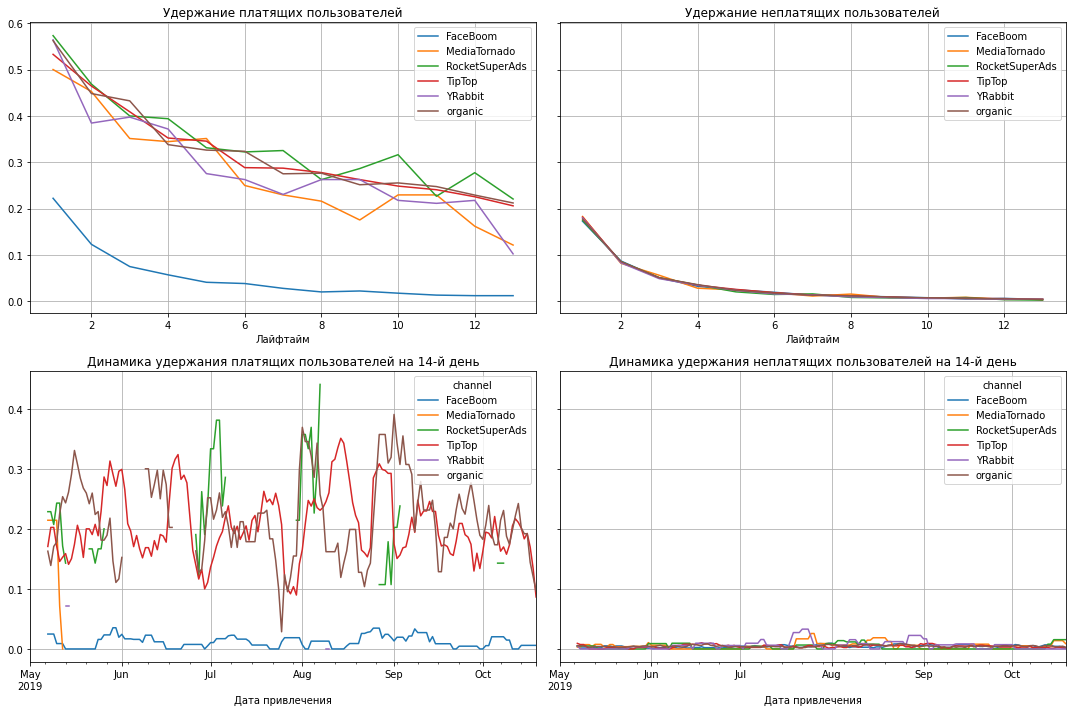

In [45]:
dimensions = ["channel"]
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('region == "United States"'),
    data_visits,
    observation_date,
    horizon_days,
    dimensions=dimensions,
)

plot_retention(retention_grouped, retention_history, horizon_days)

## Анализ удержания в США (самый крупный рынок по числу посетителей)

### Вывод 
Удержание по каналам в США:

- удержание платящих пользователей из США в канале FaceBoom самое низкое по сравнению с остальными каналами на протяжении всех лайфтаймов, а это один из крупнейших каналов на изучаемой территории. По этому и остальным каналам наблюдается тренд к снижению от 0 к 14 лайфтайму. 
- динамика удержания на 14 день покупателей крайне волатильна, часть каналов имеет прерывания (отсутствия удержания). Платящие пользователи канала MediaTornado показывают отсутвия удержания после мая, однако среди неплатящих пользователей привлеченных этим каналом удержание имеется.
- удержание неплатящих пользователей всех каналов находится на примерно однаковом уровне.


# Вывод итоговый

Среди причин неэффективности маркетинговых мероприятий можно выделить наиболее значимые: 
    
- наибольшее число как посетителей, так и покупателей услуг сервиса находится в США. При этом наблюдается значительный рост стоимости привлечения покупателей из этой страны в июне. 
- конверсия посетителей в покупатели среди северо-американских пользователей гораздо выше европейских.     
- а удержание покупателей из США самое низкое по сравнению и европейскими покупателями.  
    
В качестве рекомендаций для улучшения показателей работы сервиса можно предложить:  
- совместно с отделом разработки выяснить наличие технических проблем для покупателей из США  
- снизить издержки на привлечение посетителей в США путем поиска новых каналов   
- усилить рекламу в европейском секторе    
- работать над улучшением сервиса, чтобы повысить удержание покупателей   
